In [1]:
#Import Relevant Libraries and read the json file 

import numpy as np
import pandas as pd 
import json
import matplotlib.pyplot as plt
from datetime import datetime, date
from functools import reduce

transaction = "transaction-data-adhoc-analysis.json"

df = pd.read_json(transaction)
df['transaction_date'] = df['transaction_date'].str[:-3] # Modify transaction_date to concise entry (i.e. Months)

In [2]:
# Functions to determine types of customers (Repeaters, Inactive and Engaged); Iterate through entries via iterrows() and for loops, as seen below: 
grouped = df.groupby(by='transaction_date')['username'].unique() #Unique usernames grouped by their transaction date (month) 
dates = df['transaction_date'].unique().tolist() #Returns list of unqiue transaction months 

def getRepeaters(repeaters, item): 
    curr_trans = item[1][1] # First array, usernames 
    idx = int(item[0])
    if idx > 0:
        prev_trans = grouped[idx-1]
        count = reduce(lambda total, curr_trans: total + 1 if curr_trans in prev_trans else total, curr_trans, 0) #lambda total if username in this month is IN last month, else make total 0 or append 0 
        repeaters[dates[idx]] = count # Repeaters are sorted according to the month they fall under
        return repeaters
    
    repeaters[dates[idx]] = 0 # For January, return 0 because idx < 0
    return repeaters
    
Repeaters = reduce(getRepeaters, enumerate(grouped.iteritems()), {}) # Reduce getRepeaters function to repeaters (input =  enumerate(grouped.iteritems())) in item (input = empty dictionary {})

def getInactive(inactive, item):
    idx = int(item[0])
    usernames = item[1][1] # Initial starting array, first username
    
    for username in usernames: # First loop iterates through current month's array of usernames
        next_Groups = grouped[idx+1:]
        for group_Idx, next_Group in enumerate(next_Groups): # Second loop iterates through each succedding month's individual array of usernames
            if not username in next_Group:  # This condition is if the customer hasn't bought this month but has bought previously
                if inactive.get(dates[group_Idx+idx+1]): 
                    inactive[dates[group_Idx+idx+1]][username] = True # Customer is counted for failing to purchase this month
                else:
                    inactive[dates[group_Idx+idx+1]] = { }
                    inactive[dates[group_Idx+idx+1]][username] = True # Customer is counted for failing to purchase this month
                break

    return inactive

inactive = reduce(getInactive, enumerate(grouped.iteritems()), { }) # Reduce getInactive function to engaged (input =  enumerate(grouped.iteritems())) in item (input = { })
Inactive = {} 
Inactive[dates[0]] = 0 # For January, return 0 because idx < 0
for attr in inactive:
    Inactive[attr] = len(inactive[attr])  # Ensure that all months are preserved in output
    
def getEngaged(engaged, item):
    idx = int(item[0])
    usernames = item[1][1]  # Initial starting array, first username
    if idx != 0: 
        return engaged 

    for username in usernames: # First loop iterates through current month's array of usernames
        next_Groups = grouped[idx+1:] 
        engaged[dates[0]][username] = True 
        for group_Idx, next_Group in enumerate(next_Groups): # Second loop iterates through each succedding month's individual array of usernames
            if username in next_Group: # This condition if the customer bought next month
                if not engaged.get(dates[group_Idx+idx+1]):
                    engaged[dates[group_Idx+idx+1]] = { } # Customer is no longer counted after they failed to purchase in future months
                engaged[dates[group_Idx+idx+1]][username] = True # Customer is True on the months they consistently buy
            else:
                break 

    return engaged

init_Engaged = {}
init_Engaged[dates[0]] = {} # Empty set to preserve January values
engaged = reduce(getEngaged, enumerate(grouped.iteritems()), init_Engaged) # Reduce getEngaged function to engaged (input =  enumerate(grouped.iteritems())) in item (input = initEngaged which is just {})
Engaged = { }

for attr in engaged:
    Engaged[attr] = len(engaged[attr]) # Ensure that all months are preserved in output


In [3]:
# Create new dataframe from dictionaries of 3 customer types 
customer_types_df = pd.DataFrame.from_dict(data=[Repeaters, Inactive, Engaged], orient="columns")
customer_types_df.index.names = ['Type of Customer']
customer_types_df = customer_types_df.rename(index={0:'Repeaters', 1:'Inactive', 2:'Engaged'})
customer_types_df.columns = ['2022/01 Count','2022/02 Count','2022/03 Count','2022/04 Count','2022/05 Count','2022/06 Count']
customer_types_df.reset_index(inplace=True)
customer_types_df

,Type of Customer,2022/01 Count,2022/02 Count,2022/03 Count,2022/04 Count,2022/05 Count,2022/06 Count
0,Repeaters,0,5167,5239,5191,5126,5208
1,Inactive,0,1416,1391,1467,1442,1379
2,Engaged,6583,5167,4141,3304,2685,2210


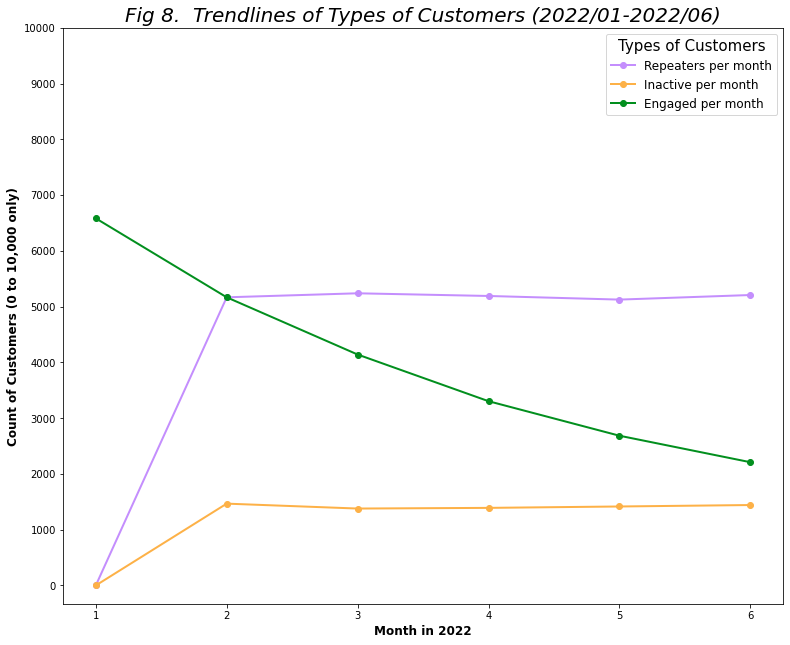

In [4]:
# ADDITIONAL VISUAL #8: Trendlines of Types of Customers
fig = plt.figure(figsize = (10,8))
ax = fig.add_axes([0,0,1,1])
x_month_number = pd.factorize(df['transaction_date'].unique())[0] + 1
x = x_month_number
myRepeaters_plot = list(Repeaters.values())
myInactive_plot = list(Inactive.values())
myEngaged_plot = list(Engaged.values())

# Plot types of customers
ax.plot(x,myRepeaters_plot,label = "Repeaters per month", lw = 2.0 ,marker = "o",color = 'xkcd:liliac')
ax.plot(x,myInactive_plot,label = "Inactive per month", lw = 2.0 ,marker = "o",color = 'xkcd:butterscotch')
ax.plot(x,myEngaged_plot,label = "Engaged per month", lw = 2.0 ,marker = "o",color = 'xkcd:emerald green')

# Set title, labels, and legend
plt.title('Fig 8.  Trendlines of Types of Customers (2022/01-2022/06)', fontstyle = 'italic', fontsize = 20)
plt.xlabel('Month in 2022', fontweight = 'bold', fontsize = 12)
plt.ylabel('Count of Customers (0 to 10,000 only)', fontweight = 'bold', fontsize = 12)
ax.set_yticks(np.arange(0, 11_000, 1_000))
plt.legend(loc=1, title= "Types of Customers", title_fontsize = '15', fontsize = '12')
plt.savefig('8_scatter_trendlines_customers.jpg', bbox_inches='tight')

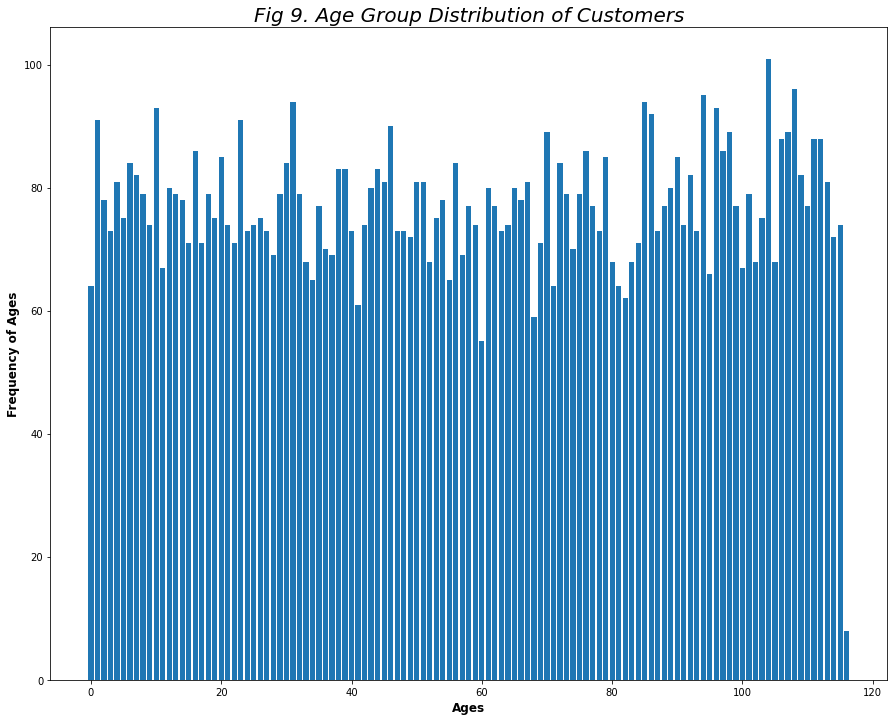

In [5]:
# ADDITIONAL VISUAL #9: Customer Age Demographics (Histogram-type Bar graph)
def age(birthdate):
    today = date.today()
    dateborn = datetime.strptime(birthdate, "%Y/%m/%d").date()
    month_before_or_after = ((dateborn.month, dateborn.day) > (today.month, today.day))
    return today.year - dateborn.year - month_before_or_after

df['age'] = df['birthdate'].apply(age)
unique_age = df.groupby(['age'])['username'].unique().to_dict() #unique usernames grouped by their birthdate (month)
age_count = []
for i in range(len(unique_age.keys())):
    username_count = len(unique_age[i])
    age_count.append(username_count)

plt.figure(figsize=(15,12))
plt.bar(range(len(unique_age.keys())), age_count)
plt.ylabel('Frequency')
plt.title('Fig 9. Age Group Distribution of Customers', fontstyle = 'italic', fontsize = 20)
plt.xlabel('Ages', fontweight = 'bold', fontsize = 12)
plt.ylabel('Frequency of Ages', fontweight = 'bold', fontsize = 12)
plt.savefig('9_bar_customer_age.jpg', bbox_inches='tight')